In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from correlation import c_clustering
from collections import defaultdict
import networkx as nx
import random
from fairness_goodness_computation import *

#### Load the Dataset


In [2]:
df = pd.read_csv("soc-sign-bitcoinotc.csv")  # Reading the data
df = df.sort_values(by="Timestamp")  # Sorting the data based on the timestamp

#### Data Preprocessing


In [3]:
# Normalizing the weights
df.Weight /= 10  # Reducing weights to -1 to 1 range:
df.Weight = df.Weight - df.Weight.mean()
print(df.head())

# Splitting the data into train and test
split = int(len(df) / 8)  # Using first 12.5% data for initial graph
train = df.iloc[:split, :]
test = df.iloc[split:, :]
print("Train shape: ", train.shape)

# Creating the initial graph
G = nx.from_pandas_edgelist(
    train, source="Source", target="Target", edge_attr="Weight", create_using=nx.DiGraph
)  # Creating the initial graph
print(G)
H = G.copy()  # Creating a copy of the initial graph

   Source  Target    Weight   Timestamp
0       6       2  0.298797  1289241912
1       6       5  0.098797  1289241942
2       1      15 -0.001203  1289243140
3       4       3  0.598797  1289245277
4      13      16  0.698797  1289254254
Train shape:  (4449, 4)



#### Computing Fairness & Goodness


In [4]:
# Computing Fairness and Goodness
fairness, goodness = compute_fairness_goodness(H)

# Setting node attributes to the graph H
nx.set_node_attributes(H, fairness, "fairness")
nx.set_node_attributes(H, goodness, "goodness")

-----------------
Iteration number 0
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 47.41, 0.00
-----------------
Iteration number 1
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 3.28, 5.98
-----------------
Iteration number 2
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.14, 0.29
-----------------
Iteration number 3
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.01, 0.02
-----------------
Iteration number 4
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.00, 0.00
-----------------
Iteration number 5
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.00, 0.00
-----------------
Iteration number 6
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.00, 0.00
-----------------
Iteration number 7
Updating goodness

#### Correlation Clustering


In [5]:
## Doing co-relation clustering for H's copy

CC = c_clustering(
    H.copy(), delta=1 / 200, complete_graph=True
)  # Computing the co-relation clustering
clusters = CC.run()  # Running the co-relation clustering
print(len(clusters))  # Printing the number of clusters

Cluster:  147
Cluster:  5
Cluster:  70
Cluster:  1
Cluster:  1
Cluster:  72
Cluster:  1
Cluster:  1
Cluster:  174
Cluster:  2
Cluster:  1
Cluster:  1
Cluster:  81
Cluster:  29
Cluster:  108
Cluster:  1
Cluster:  1
Cluster:  1
Cluster:  12
Cluster:  34
Cluster:  1
Cluster:  1
Cluster:  104
Cluster:  46
Cluster:  16
Cluster:  1
Cluster:  1
Cluster:  1
Cluster:  55
Cluster:  1
Cluster:  21
Cluster:  1
Cluster:  12
Cluster:  1
Cluster:  1
Cluster:  1
Cluster:  3
37


In [6]:
dic = dict(zip(range(len(clusters)), clusters))  # Creating a dictionary of clusters
print(dic)

{0: {2, 3, 4, 5, 6, 8, 9, 10, 15, 16, 17, 19, 20, 21, 23, 25, 26, 28, 31, 32, 33, 34, 36, 37, 39, 44, 45, 46, 47, 51, 52, 53, 54, 55, 56, 57, 61, 62, 65, 66, 68, 69, 70, 71, 72, 74, 76, 77, 78, 79, 80, 81, 83, 86, 87, 88, 89, 93, 94, 95, 96, 97, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 119, 120, 122, 125, 127, 129, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 152, 153, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200}, 1: {201, 166, 41, 154, 75}, 2: {257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 271, 272, 273, 274, 60, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245

#### Graph completion using fairness and goodness


In [7]:
complete_graph = True  # Setting the complete graph parameter to True
weights = nx.get_edge_attributes(H, "Weight")
in_p_old = defaultdict(int)  # weights of positive edges going into the cluster
out_p_old = defaultdict(int)  # weights of positive edges going out of the cluster
in_n_old = defaultdict(int)  # weights of negative edges going into the cluster
out_n_old = defaultdict(int)  # weights of negative edges going out of the cluster
N_in_p_old = defaultdict(int)  # number of positive edges going into the cluster
N_out_p_old = defaultdict(int)  # number of positive edges going out of the cluster
N_in_n_old = defaultdict(int)  # number of negative edges going into the cluster
N_out_n_old = defaultdict(int)  # number of negative edges going out of the cluster
preds = {}

for i in range(len(clusters)):
    for u in clusters[i]:
        for v in H.neighbors(u):
            if v in clusters[i]:
                if weights[(u, v)] > 0:
                    in_p_old[i] += weights[(u, v)]
                    N_in_p_old[i] += 1
                else:
                    in_n_old[i] += weights[(u, v)]
                    N_in_n_old[i] += 1
            else:
                if weights[(u, v)] > 0:
                    out_p_old[i] += weights[(u, v)]
                    N_out_p_old[i] += 1
                else:
                    out_n_old[i] += weights[(u, v)]
                    N_out_n_old[i] += 1

        if (
            complete_graph
        ):  # complete incomplete graph by weight prediction using fairness-goodness
            for v in nx.non_neighbors(H, u):
                if v in clusters[i]:
                    if fairness[u] * goodness[v] > 0:
                        in_p_old[i] += fairness[u] * goodness[v]
                        preds[(u, v)] = fairness[u] * goodness[v]
                        N_in_p_old[i] += 1
                    else:
                        in_n_old[i] += fairness[u] * goodness[v]
                        preds[(u, v)] = fairness[u] * goodness[v]
                        N_in_n_old[i] += 1
                else:
                    if fairness[u] * goodness[v] > 0:
                        out_p_old[i] += fairness[u] * goodness[v]
                        preds[(u, v)] = fairness[u] * goodness[v]
                        N_out_p_old[i] += 1
                    else:
                        out_n_old[i] += fairness[u] * goodness[v]
                        preds[(u, v)] = fairness[u] * goodness[v]
                        N_out_n_old[i] += 1

#### Trustworthiness metric


In [8]:

metrics_1 = [
    (in_p_old[i] + abs(out_n_old[i])) / len(clusters[i]) for i in range(len(clusters))
]

metrics_2 = [
    (in_p_old[i]+ abs(out_n_old[i]) + out_p_old[i] +abs(in_n_old[i]))/len(clusters[i]) for i in range(len(clusters))
]

metrics_3 = [
    (in_p_old[i] + abs(out_n_old[i])) / len(H.edges) for i in range(len(clusters))
]


In [9]:
metrics_4 = [(out_p_old[i] +abs(in_n_old[i]))/len(clusters[i]) for i in range(len(clusters))]

metrics_5 = [(out_p_old[i] +abs(in_n_old[i]))/len(H.edges) for i in range(len(clusters))]

#metrics_7 = [in_p_old[i] / (in_p_old[i] + in_n_old[i]) for i in range(len(clusters))]

# metrics_8 = [(in_p_old[i] + out_p_old[i]) / (in_n_old[i] + out_n_old[i] + 0.001) for i in range(len(clusters))]

In [10]:
fairness_old = fairness
goodness_old = goodness

#### Adding new nodes to the graph


In [11]:
H_add = H.copy()  # Creating a copy of the initial graph for adding nodes and edges

In [12]:
## Creating dictionary for the cluster and degree corresponding to each node in it

cluster_degree_dict = {}
for i in range(len(clusters)):
    rand = []
    for j in clusters[i]:
        rand.append((j, H.degree[j]))
    sorted_list = sorted(rand, key=lambda x: x[1], reverse=True)
    cluster_degree_dict[i] = sorted_list

print(cluster_degree_dict)

{0: [(2, 66), (104, 60), (132, 59), (4, 53), (21, 42), (39, 38), (62, 36), (143, 35), (149, 35), (77, 33), (113, 33), (135, 29), (110, 26), (141, 26), (23, 24), (36, 22), (45, 22), (178, 22), (6, 21), (80, 20), (142, 20), (17, 19), (37, 19), (57, 19), (134, 19), (78, 16), (100, 16), (167, 16), (186, 16), (15, 15), (54, 14), (69, 14), (81, 14), (177, 14), (200, 14), (28, 13), (114, 13), (163, 13), (19, 12), (51, 12), (96, 12), (33, 11), (56, 11), (125, 11), (156, 11), (181, 11), (3, 10), (25, 10), (26, 10), (61, 10), (68, 10), (70, 10), (88, 10), (101, 10), (108, 10), (111, 10), (152, 10), (153, 10), (10, 9), (93, 9), (148, 9), (179, 9), (20, 8), (109, 8), (112, 8), (150, 8), (180, 8), (95, 7), (139, 7), (164, 7), (173, 7), (176, 7), (184, 7), (5, 6), (32, 6), (34, 6), (76, 6), (97, 6), (119, 6), (161, 6), (183, 6), (194, 6), (199, 6), (72, 5), (127, 5), (129, 5), (146, 5), (147, 5), (31, 4), (44, 4), (47, 4), (53, 4), (87, 4), (89, 4), (107, 4), (137, 4), (138, 4), (155, 4), (157, 4), 

In [13]:
## Calculating the average weight of the edges connected to a particular node
def avg_weight(G, node):
    weights = nx.get_edge_attributes(G, "Weight")
    sum = 0
    for i in G.neighbors(node):
        sum += weights[(node, i)]
    return sum / len(list(G.neighbors(node)))

In [14]:
for k in range(1, 11):  # Adding 10 nodes to the graph
    new_node = max(list(H.nodes)) + k  # Creating a new node
    for i in range(len(clusters)):
        if len(clusters[i]) > 10:  # Choosing clusters with more than 10 nodes
            nodes = cluster_degree_dict[i][
                :10
            ]  # Choosing top 10 nodes with highest degree in the cluster
            ssum = sum(
                node[1] for node in nodes
            )  # Calculating sum of degrees of the top 10 nodes
            probs = [
                node[1] / ssum for node in nodes
            ]  # Calculating probability of choosing each node
            nodes_list = [
                node[0] for node in nodes
            ]  # Creating a list of nodes corresponding to it
            chosen_nodes = random.choices(
                nodes_list, probs, k=2
            )  # Choosing 2 nodes from the cluster based on the probability

            for (node) in chosen_nodes:  # Adding edges between the new node and the chosen nodes
                weight = avg_weight(H, node)  # Weight of the edge is the average weight of the edges of the chosen node
                H_add.add_edge(
                    node, new_node, Weight=weight
                )  # Adding the edge to the graph


In [15]:
nx.info(H_add)


'Name: \nType: DiGraph\nNumber of nodes: 1020\nNumber of edges: 4718\nAverage in degree:   4.6255\nAverage out degree:   4.6255'

In [16]:
fairness, goodness = compute_fairness_goodness(H_add)
nx.set_node_attributes(H_add, fairness, "fairness")
nx.set_node_attributes(H_add, goodness, "goodness")

-----------------
Iteration number 0
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 47.66, 0.00
-----------------
Iteration number 1
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 3.28, 6.07
-----------------
Iteration number 2
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.13, 0.29
-----------------
Iteration number 3
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.01, 0.02
-----------------
Iteration number 4
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.00, 0.00
-----------------
Iteration number 5
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.00, 0.00
-----------------
Iteration number 6
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.00, 0.00
-----------------
Iteration number 7
Updating goodness

#### Predicting the weights of the graph after introduction of new nodes


In [17]:
complete_graph = True
weights = nx.get_edge_attributes(H_add, "Weight")
# initialize the metrics
in_p = defaultdict(int)
out_p = defaultdict(int)
in_n = defaultdict(int)
out_n = defaultdict(int)
N_in_p = defaultdict(int)
N_out_p = defaultdict(int)
N_in_n = defaultdict(int)
N_out_n = defaultdict(int)

preds_new = {}

for i in range(len(clusters)):
    for u in clusters[i]:
        for v in H_add.neighbors(u):
            if v in clusters[i]:
                if weights[(u, v)] > 0:
                    in_p[i] += weights[(u, v)]
                    N_in_p[i] += 1
                else:
                    in_n[i] += weights[(u, v)]
                    N_in_n[i] += 1
            else:
                if weights[(u, v)] > 0:
                    out_p[i] += weights[(u, v)]
                    N_out_p[i] += 1
                else:
                    out_n[i] += weights[(u, v)]
                    N_out_n[i] += 1

        if (
            complete_graph
        ):  # If the graph is complete, we need to add the edges between the nodes that are not neighbors
            for v in nx.non_neighbors(H_add, u):
                if v in clusters[i]:
                    if fairness[u] * goodness[v] > 0:
                        in_p[i] += fairness[u] * goodness[v]
                        preds_new[(u, v)] = fairness[u] * goodness[v]
                        N_in_p[i] += 1
                    else:
                        in_n[i] += fairness[u] * goodness[v]
                        preds_new[(u, v)] = fairness[u] * goodness[v]
                        N_in_n[i] += 1
                else:
                    if fairness[u] * goodness[v] > 0:
                        out_p[i] += fairness[u] * goodness[v]
                        preds_new[(u, v)] = fairness[u] * goodness[v]
                        N_out_p[i] += 1
                    else:
                        out_n[i] += fairness[u] * goodness[v]
                        preds_new[(u, v)] = fairness[u] * goodness[v]
                        N_out_n[i] += 1

In [18]:
preds  ## Predicted weights of missing edges before adding new nodes


{(2, 6): 0.16649967237092353,
 (2, 5): 0.11809127102907874,
 (2, 15): 0.06957835659621907,
 (2, 16): 0.6314231133608822,
 (2, 10): 0.6111334992208025,
 (2, 8): 0.33725724849963146,
 (2, 17): 0.16388386292097754,
 (2, 23): 0.11465772792939553,
 (2, 25): 0.23335558294436629,
 (2, 26): 0.05424711513708448,
 (2, 28): 0.05537069480764223,
 (2, 29): 0.05437369303220599,
 (2, 31): 0.043586052615679834,
 (2, 32): -0.0010756371526204412,
 (2, 34): -0.001078797010642739,
 (2, 35): 0.04404104727732238,
 (2, 36): 0.07187451458300298,
 (2, 37): 0.03863382552169936,
 (2, 44): -0.0010648093896817531,
 (2, 39): 0.12155075991018513,
 (2, 45): 0.14906235969711776,
 (2, 19): 0.20420953919157622,
 (2, 46): -0.0010900539243746407,
 (2, 47): 0.08819830380198862,
 (2, 51): 0.17461482133850684,
 (2, 52): -0.001101024710480232,
 (2, 53): 0.1773727739983983,
 (2, 41): 0.023791567091841753,
 (2, 55): -0.0010762880912462357,
 (2, 57): 0.10462399509213519,
 (2, 61): 0.15874270207964192,
 (2, 65): -0.00109237108486

In [19]:
preds_new  ## Predicted weights of missing edges after adding new nodes


{(2, 6): 0.16706866295793235,
 (2, 5): 0.11868870746254177,
 (2, 15): 0.06974785123344865,
 (2, 16): 0.634431635268241,
 (2, 10): 0.6131909506867421,
 (2, 8): 0.3378884506401772,
 (2, 17): 0.1647966760856105,
 (2, 23): 0.11506977386320237,
 (2, 25): 0.2342319513982787,
 (2, 26): 0.054449649193463213,
 (2, 28): 0.05560110842133291,
 (2, 29): 0.054544128104711244,
 (2, 31): 0.04384524712689671,
 (2, 32): -0.0010795041151606388,
 (2, 34): -0.001084325414098271,
 (2, 35): 0.044179878315502956,
 (2, 36): 0.07214732764971281,
 (2, 37): 0.03874829139465095,
 (2, 44): -0.0010694797880455025,
 (2, 39): 0.12199004864047552,
 (2, 45): 0.14947002120242187,
 (2, 19): 0.20517821499459102,
 (2, 46): -0.0010926619718260669,
 (2, 47): 0.08872098483233444,
 (2, 51): 0.17504399118427574,
 (2, 52): -0.001103716790121278,
 (2, 53): 0.17810800294349338,
 (2, 41): 0.023860428324092752,
 (2, 55): -0.0010813421998952292,
 (2, 57): 0.10491663457768588,
 (2, 61): 0.15951257753833392,
 (2, 65): -0.001095012102306

In [20]:
# predicted edge dict
# cluster_edges consist of key, value pair as edges and their corresponding predicted weights

cluster_edges = (
    {}
)  # Dictionary to store the predicted edges between the nodes in the cluster
for i in dic.keys():
    if len(dic[i]) > 10:  # Choosing clusters with more than 10 nodes
        nodes_in_cluster = list(dic[i])  # Creating a list of nodes in the cluster
        for u, v in preds.keys():  # Iterating through the predicted edges
            if (
                u in nodes_in_cluster and v in nodes_in_cluster
            ):  # If both the nodes are in the cluster
                if (
                    i not in cluster_edges.keys()
                ):  # If the cluster is not in the dictionary, add it
                    cluster_edges[i] = list()
                cluster_edges[i].append(
                    ((u, v), preds[(u, v)])
                )  # Add the edge and the predicted weight to the dictionary

In [21]:
print(cluster_edges)

{0: [((2, 6), 0.16649967237092353), ((2, 5), 0.11809127102907874), ((2, 15), 0.06957835659621907), ((2, 16), 0.6314231133608822), ((2, 10), 0.6111334992208025), ((2, 8), 0.33725724849963146), ((2, 17), 0.16388386292097754), ((2, 23), 0.11465772792939553), ((2, 25), 0.23335558294436629), ((2, 26), 0.05424711513708448), ((2, 28), 0.05537069480764223), ((2, 31), 0.043586052615679834), ((2, 32), -0.0010756371526204412), ((2, 34), -0.001078797010642739), ((2, 36), 0.07187451458300298), ((2, 37), 0.03863382552169936), ((2, 44), -0.0010648093896817531), ((2, 39), 0.12155075991018513), ((2, 45), 0.14906235969711776), ((2, 19), 0.20420953919157622), ((2, 46), -0.0010900539243746407), ((2, 47), 0.08819830380198862), ((2, 51), 0.17461482133850684), ((2, 52), -0.001101024710480232), ((2, 53), 0.1773727739983983), ((2, 55), -0.0010762880912462357), ((2, 57), 0.10462399509213519), ((2, 61), 0.15874270207964192), ((2, 65), -0.0010923710848659755), ((2, 56), 0.07041572827868826), ((2, 66), 0.084424792

In [22]:
# new predicted edge dict
# cluster_new_edges consist of key, value pair as edges and their corresponding predicted weights for the edges after addition of new nodes

cluster_new_edges = {}
for i in dic.keys():
    if len(dic[i]) > 10:
        nodes_in_cluster = list(dic[i])
        for u, v in preds_new.keys():
            if u in nodes_in_cluster and v in nodes_in_cluster:
                if i not in cluster_new_edges.keys():
                    cluster_new_edges[i] = list()
                cluster_new_edges[i].append(((u, v), preds_new[(u, v)]))

In [23]:
print(cluster_new_edges)

{0: [((2, 6), 0.16706866295793235), ((2, 5), 0.11868870746254177), ((2, 15), 0.06974785123344865), ((2, 16), 0.634431635268241), ((2, 10), 0.6131909506867421), ((2, 8), 0.3378884506401772), ((2, 17), 0.1647966760856105), ((2, 23), 0.11506977386320237), ((2, 25), 0.2342319513982787), ((2, 26), 0.054449649193463213), ((2, 28), 0.05560110842133291), ((2, 31), 0.04384524712689671), ((2, 32), -0.0010795041151606388), ((2, 34), -0.001084325414098271), ((2, 36), 0.07214732764971281), ((2, 37), 0.03874829139465095), ((2, 44), -0.0010694797880455025), ((2, 39), 0.12199004864047552), ((2, 45), 0.14947002120242187), ((2, 19), 0.20517821499459102), ((2, 46), -0.0010926619718260669), ((2, 47), 0.08872098483233444), ((2, 51), 0.17504399118427574), ((2, 52), -0.001103716790121278), ((2, 53), 0.17810800294349338), ((2, 55), -0.0010813421998952292), ((2, 57), 0.10491663457768588), ((2, 61), 0.15951257753833392), ((2, 65), -0.0010950121023062449), ((2, 56), 0.07078317220996183), ((2, 66), 0.084724023446

In [24]:
# difference of predicted edge weight 
# It stores the difference between the earlier predicted and the newly predicted weights of the edges in the cluster
diff_in_weights_cluster = {}
for i in range(len(clusters)):
    if len(dic[i]) > 10:
        diff_in_weights_cluster[i] = 0
        if i in cluster_edges.keys() and i in cluster_new_edges.keys():
            for j in range(len(cluster_edges[i])):
                ((u1, v1), w1) = cluster_edges[i][j]
                ((u2, v2), w2) = cluster_new_edges[i][j]
                diff_in_weights_cluster[i] += abs(w1 - w2)
            diff_in_weights_cluster[i] = diff_in_weights_cluster[i] / len(
                cluster_edges[i]
            )

In [25]:
# metrics = []

# for i in range(len(clusters)):
#     ssum = 0
#     for j in clusters[i]:
#         ssum += fairness_old[j] + goodness_old[j]
#     metrics.append(ssum / len(clusters[i]))


In [26]:
list(diff_in_weights_cluster.keys())

[0, 2, 5, 8, 12, 13, 14, 18, 19, 22, 23, 24, 28, 30, 32]

In [27]:
# a = [[i, metrics[i]] for i in list(diff_in_weights_cluster.keys())]
# print(a)


In [28]:
# a_np = np.array(a)
# plt.plot(a_np[:, 0], a_np[:, 1])

In [29]:
sorted(diff_in_weights_cluster.items(), key=lambda item: item[1])

[(14, 9.64215212803577e-05),
 (8, 0.00010052363524867365),
 (0, 0.00010516853681080037),
 (2, 0.00011005388489087197),
 (13, 0.0001254526012844632),
 (12, 0.00013073186178423943),
 (5, 0.00018296347197609977),
 (28, 0.00023204083378818496),
 (24, 0.0002676792157342482),
 (23, 0.0002801633227517404),
 (22, 0.0002978111771784282),
 (19, 0.0003837119947296867),
 (32, 0.00048730630642285466),
 (30, 0.0006722931304478541),
 (18, 0.0013982905698167783)]

In [30]:
def plot_creator(metrics, diff_in_weights_cluster):
    # Create a list of boolean values indicating which points to highlight
    highlight = [True if i in list(diff_in_weights_cluster.keys()) else False for i in range(len(metrics))]

    # Create a list of colors for each point depending on whether to highlight or not
    colors = ['blue' if not h else 'red' for h in highlight]
    
    fig,ax = plt.subplots(figsize=(16,4))
    # Create a line plot with highlighted points in red
    ax.set_xlabel("Cluster Number")
    ax.set_ylabel("Metric Value")
    ax.plot(metrics, color='blue')
    ax.scatter(range(len(metrics)), metrics, c=colors)
    for i, h in enumerate(highlight):
        if h:
            ax.text(i, metrics[i], f'{i}:{round(diff_in_weights_cluster[i],5)}', ha='center', va='bottom', fontsize=10)
    plt.show()

In [32]:
diff_in_weights_cluster

{0: 0.00010516853681080037,
 2: 0.00011005388489087197,
 5: 0.00018296347197609977,
 8: 0.00010052363524867365,
 12: 0.00013073186178423943,
 13: 0.0001254526012844632,
 14: 9.64215212803577e-05,
 18: 0.0013982905698167783,
 19: 0.0003837119947296867,
 22: 0.0002978111771784282,
 23: 0.0002801633227517404,
 24: 0.0002676792157342482,
 28: 0.00023204083378818496,
 30: 0.0006722931304478541,
 32: 0.00048730630642285466}

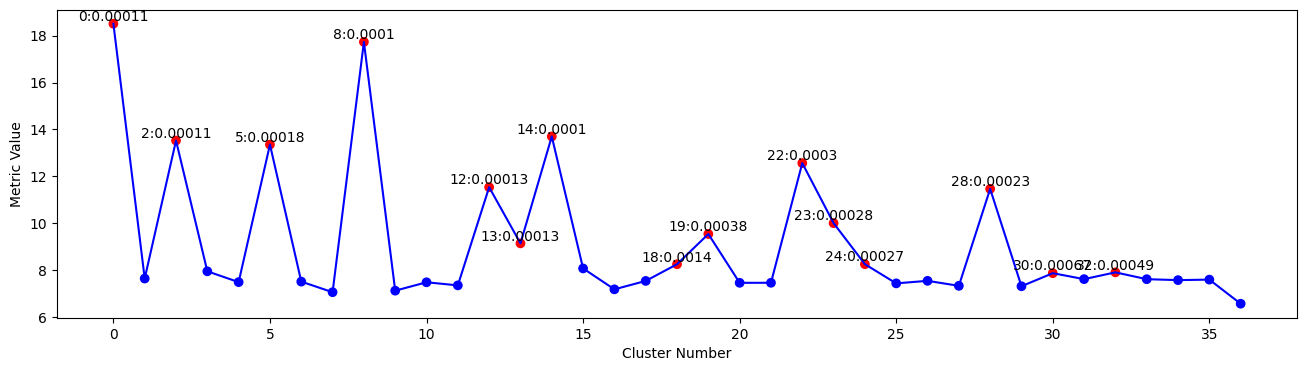

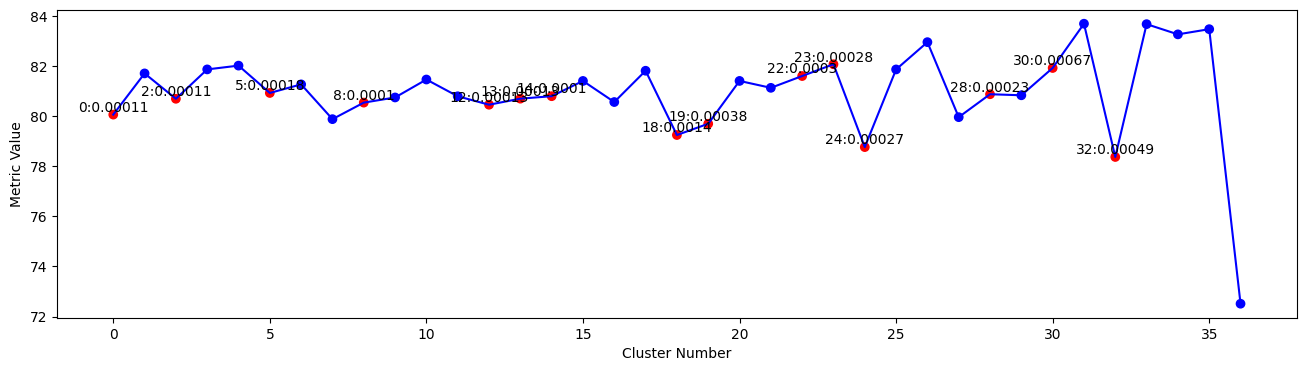

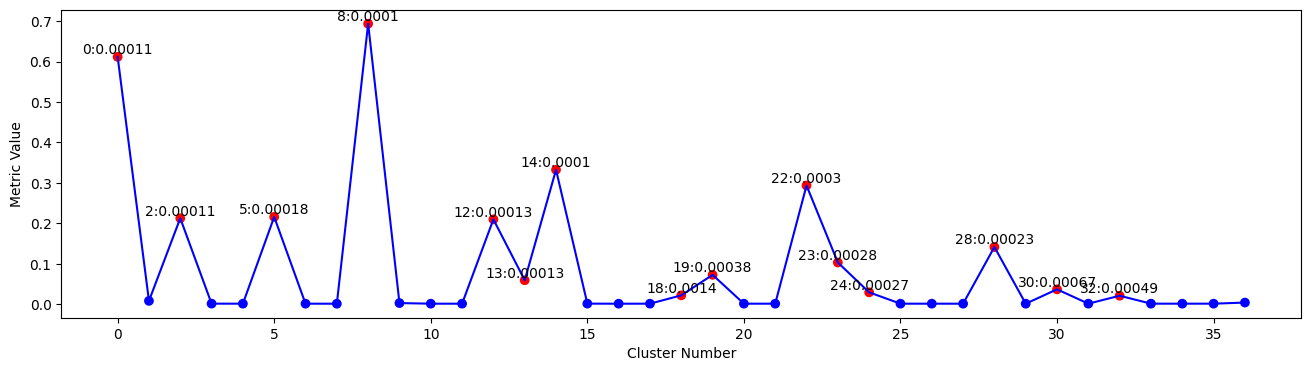

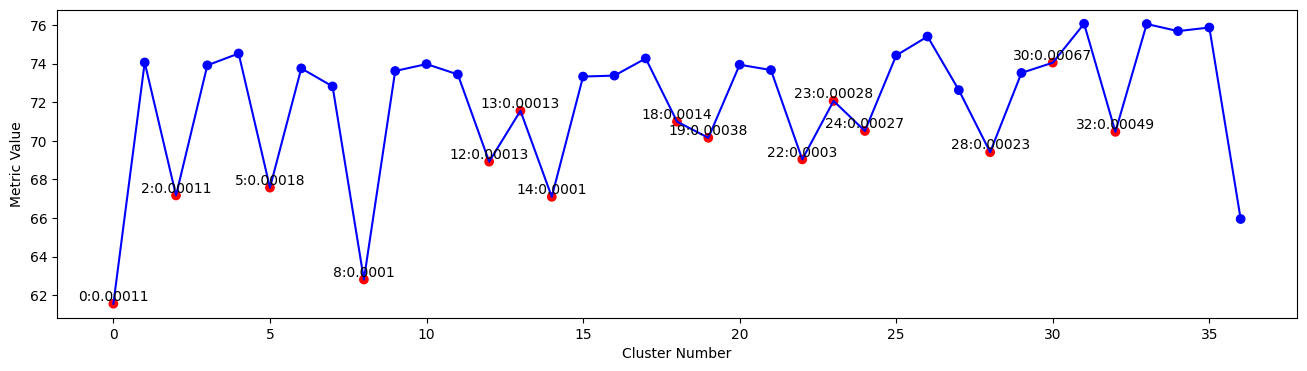

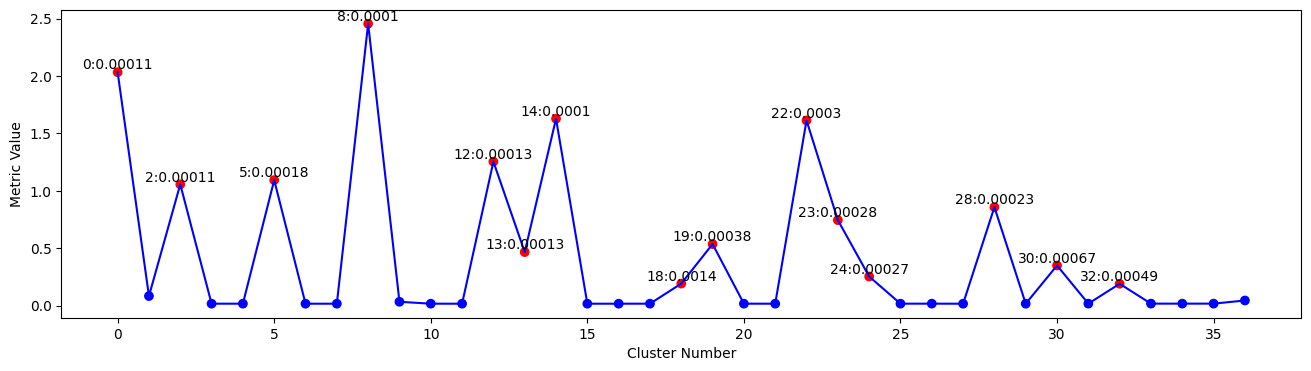

In [31]:
plot_creator(metrics_1, diff_in_weights_cluster)
# plot_creator(metrics_2, diff_in_weights_cluster)
plot_creator(metrics_3, diff_in_weights_cluster)
plot_creator(metrics_4, diff_in_weights_cluster)
plot_creator(metrics_5, diff_in_weights_cluster)